<a href="https://colab.research.google.com/github/s-ahmed6786/GANs-Concept-Car-Generator/blob/main/GANProject8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the Data from google drive**

> Indented block



In [ ]:
!pip install --upgrade torchvision
!pip install --upgrade torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_DIR = ('/content/gdrive/Shareddrives/Classes/MachineLearning/GAN/PreprocessedData/data')

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 256
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

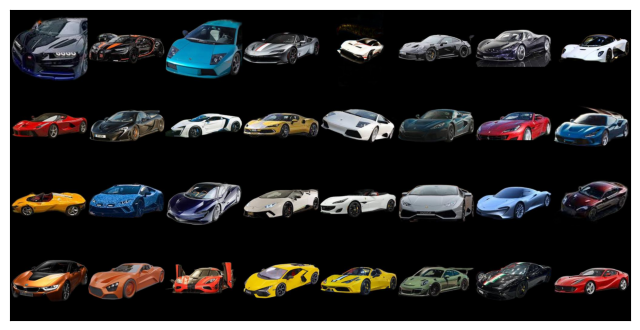

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

**Create Discriminator Model**

In [ ]:
discriminator = nn.Sequential(

    # in: 3 x 256 x 256
    nn.Conv2d(3, 256, kernel_size=4, stride=4, padding=2, bias=False),
    #nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 64 x 64

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 32 x 32

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 16 x 16

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 8 x 8

    nn.Conv2d(2048, 4096, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4096),
    nn.LeakyReLU(0.2, inplace=True),
    # # out: 4096 x 4 x 4

    nn.Conv2d(4096, 8192, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8192),
    nn.LeakyReLU(0.2, inplace=True),
    # # out: 8192 x 4 x 4

    nn.Conv2d(8192, 1, kernel_size=4, stride=1, padding=1, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

# New Section

In [ ]:
discriminator = to_device(discriminator, device)
latent_size = 64 #128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 8192, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(8192),
    nn.ReLU(True),
    # out: 8192 x 4 x 4

    nn.ConvTranspose2d(8192, 4096, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4096),
    nn.ReLU(True),
    # out: 4096 x 8 x 8

    nn.ConvTranspose2d(4096, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(True),
    # out: 2048 x 8 x 8

    nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 16 x 16

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 32 x 32

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 64 x 64

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 128 x 128


    nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

In [ ]:
#discriminator = torch.compile(discriminator)
#generator = torch.compile(generator)

torch.Size([64, 3, 256, 256])


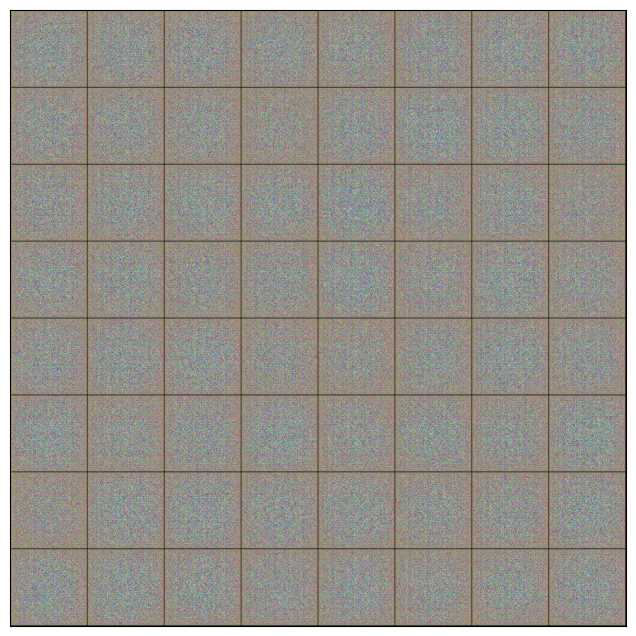

In [ ]:
xb = torch.randn(64, 64, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image
import os

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


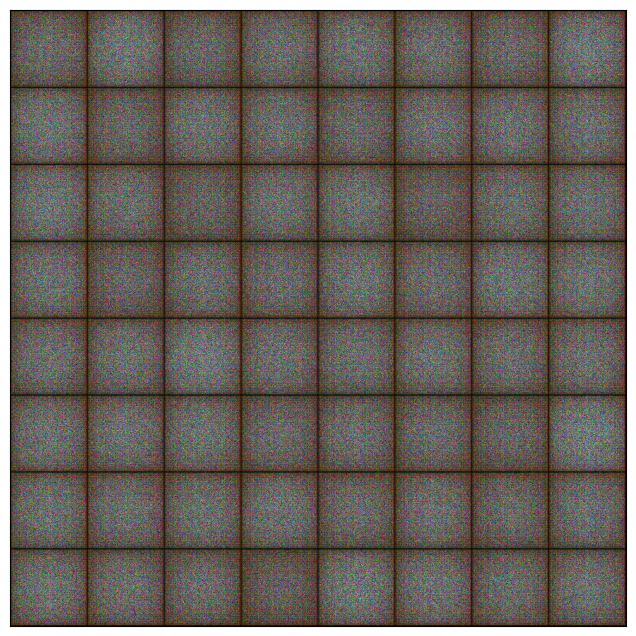

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 1.7023, loss_d: 1.5183, real_score: 0.4453, fake_score: 0.4861
Saving generated-images-0001.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 1.3605, loss_d: 3.9479, real_score: 0.0214, fake_score: 0.0958
Saving generated-images-0002.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.4542, loss_d: 6.5102, real_score: 0.0015, fake_score: 0.0326
Saving generated-images-0003.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 0.3840, loss_d: 9.2525, real_score: 0.0001, fake_score: 0.3111
Saving generated-images-0004.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.8396, loss_d: 2.5050, real_score: 0.1198, fake_score: 0.3120
Saving generated-images-0005.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.2893, loss_d: 1.9441, real_score: 0.5897, fake_score: 0.7320
Saving generated-images-0006.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 0.0223, loss_d: 1.6152, real_score: 0.2136, fake_score: 0.0684
Saving generated-images-0007.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.8859, loss_d: 3.3763, real_score: 0.0632, fake_score: 0.3585
Saving generated-images-0008.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.4142, loss_d: 0.2444, real_score: 0.9786, fake_score: 0.1580
Saving generated-images-0009.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.4918, loss_d: 0.7342, real_score: 0.5313, fake_score: 0.0956
Saving generated-images-0010.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.0957, loss_d: 0.2852, real_score: 0.9963, fake_score: 0.2415
Saving generated-images-0011.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.5171, loss_d: 3.6039, real_score: 0.0282, fake_score: 0.0345
Saving generated-images-0012.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.1453, loss_d: 3.5197, real_score: 0.0366, fake_score: 0.1885
Saving generated-images-0013.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 0.5842, loss_d: 6.5652, real_score: 0.0015, fake_score: 0.0745
Saving generated-images-0014.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.0738, loss_d: 0.8318, real_score: 0.5847, fake_score: 0.2515
Saving generated-images-0015.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.5403, loss_d: 4.4240, real_score: 0.0122, fake_score: 0.0187
Saving generated-images-0016.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 5.1924, loss_d: 1.1239, real_score: 0.8293, fake_score: 0.5730
Saving generated-images-0017.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 5.5073, loss_d: 0.0666, real_score: 0.9430, fake_score: 0.0078
Saving generated-images-0018.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.6366, loss_d: 3.5791, real_score: 0.0303, fake_score: 0.0783
Saving generated-images-0019.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 2.6085, loss_d: 4.5420, real_score: 0.0112, fake_score: 0.0466
Saving generated-images-0020.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.0247, loss_d: 1.1329, real_score: 0.7875, fake_score: 0.5641
Saving generated-images-0021.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.9411, loss_d: 4.6421, real_score: 0.0226, fake_score: 0.5464
Saving generated-images-0022.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.4915, loss_d: 0.7447, real_score: 0.9339, fake_score: 0.4801
Saving generated-images-0023.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 7.4168, loss_d: 1.6224, real_score: 0.1978, fake_score: 0.0019
Saving generated-images-0024.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.4478, loss_d: 0.2293, real_score: 0.9995, fake_score: 0.2006
Saving generated-images-0025.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.8385, loss_d: 6.8477, real_score: 0.0019, fake_score: 0.4138
Saving generated-images-0026.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.9446, loss_d: 3.4076, real_score: 0.0592, fake_score: 0.3946
Saving generated-images-0027.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.6972, loss_d: 9.9367, real_score: 0.0001, fake_score: 0.0466
Saving generated-images-0028.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.1575, loss_d: 0.2820, real_score: 0.9313, fake_score: 0.1826
Saving generated-images-0029.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.0236, loss_d: 7.4944, real_score: 0.0009, fake_score: 0.3420
Saving generated-images-0030.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 1.7003, loss_d: 1.6043, real_score: 0.2477, fake_score: 0.1837
Saving generated-images-0031.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.5653, loss_d: 1.5834, real_score: 0.2082, fake_score: 0.0138
Saving generated-images-0032.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.0241, loss_d: 1.1826, real_score: 0.7769, fake_score: 0.5834
Saving generated-images-0033.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.6130, loss_d: 6.7699, real_score: 0.0237, fake_score: 0.9309
Saving generated-images-0034.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.0467, loss_d: 0.2654, real_score: 0.7680, fake_score: 0.0015
Saving generated-images-0035.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.1453, loss_d: 0.2076, real_score: 0.9929, fake_score: 0.1788
Saving generated-images-0036.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.3928, loss_d: 0.0764, real_score: 0.9303, fake_score: 0.0041
Saving generated-images-0037.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.8887, loss_d: 1.9208, real_score: 0.1625, fake_score: 0.0970
Saving generated-images-0038.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.2895, loss_d: 0.2759, real_score: 0.9999, fake_score: 0.1832
Saving generated-images-0039.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.5701, loss_d: 0.7080, real_score: 0.5034, fake_score: 0.0214
Saving generated-images-0040.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.3506, loss_d: 0.8583, real_score: 0.9849, fake_score: 0.5414
Saving generated-images-0041.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.8083, loss_d: 0.3178, real_score: 0.9972, fake_score: 0.2291
Saving generated-images-0042.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.7805, loss_d: 0.1444, real_score: 0.9963, fake_score: 0.1288
Saving generated-images-0043.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 6.1450, loss_d: 1.6473, real_score: 0.9869, fake_score: 0.7857
Saving generated-images-0044.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.2616, loss_d: 0.2068, real_score: 0.8145, fake_score: 0.0016
Saving generated-images-0045.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 6.8630, loss_d: 0.5757, real_score: 0.9944, fake_score: 0.4241
Saving generated-images-0046.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 2.7935, loss_d: 0.0897, real_score: 0.9425, fake_score: 0.0297
Saving generated-images-0047.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.7194, loss_d: 0.3903, real_score: 0.6971, fake_score: 0.0290
Saving generated-images-0048.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.4335, loss_d: 1.9792, real_score: 0.1812, fake_score: 0.2318
Saving generated-images-0049.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 1.6836, loss_d: 4.7594, real_score: 0.0087, fake_score: 0.0130
Saving generated-images-0050.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 1.1306, loss_d: 4.1478, real_score: 0.0293, fake_score: 0.4284
Saving generated-images-0051.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 0.7282, loss_d: 11.9993, real_score: 0.0000, fake_score: 0.0142
Saving generated-images-0052.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.4208, loss_d: 0.9749, real_score: 0.9953, fake_score: 0.3982
Saving generated-images-0053.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.2087, loss_d: 0.4973, real_score: 0.8529, fake_score: 0.2755
Saving generated-images-0054.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 6.7552, loss_d: 2.8497, real_score: 1.0000, fake_score: 0.9109
Saving generated-images-0055.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.6284, loss_d: 0.0709, real_score: 0.9929, fake_score: 0.0612
Saving generated-images-0056.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.6661, loss_d: 4.6624, real_score: 0.0111, fake_score: 0.1479
Saving generated-images-0057.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.9129, loss_d: 0.2667, real_score: 0.7869, fake_score: 0.0261
Saving generated-images-0058.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.0501, loss_d: 0.3093, real_score: 0.9965, fake_score: 0.2471
Saving generated-images-0059.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 7.2102, loss_d: 1.0432, real_score: 0.9998, fake_score: 0.5952
Saving generated-images-0060.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.9176, loss_d: 1.6391, real_score: 0.2609, fake_score: 0.2444
Saving generated-images-0061.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.3204, loss_d: 0.7710, real_score: 0.9993, fake_score: 0.5152
Saving generated-images-0062.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 0.0037, loss_d: 4.2372, real_score: 0.0159, fake_score: 0.0900
Saving generated-images-0063.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.1979, loss_d: 1.2711, real_score: 0.3243, fake_score: 0.1323
Saving generated-images-0064.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 6.4384, loss_d: 0.0374, real_score: 0.9981, fake_score: 0.0347
Saving generated-images-0065.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.6306, loss_d: 0.1621, real_score: 0.8586, fake_score: 0.0096
Saving generated-images-0066.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 2.3268, loss_d: 0.0739, real_score: 0.9701, fake_score: 0.0424
Saving generated-images-0067.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.7281, loss_d: 0.9070, real_score: 0.8080, fake_score: 0.4614
Saving generated-images-0068.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.0488, loss_d: 0.2574, real_score: 0.7997, fake_score: 0.0332
Saving generated-images-0069.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.2923, loss_d: 0.1006, real_score: 0.9673, fake_score: 0.0642
Saving generated-images-0070.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.4074, loss_d: 0.0898, real_score: 0.9994, fake_score: 0.0834
Saving generated-images-0071.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 7.2073, loss_d: 0.1866, real_score: 0.9061, fake_score: 0.0831
Saving generated-images-0072.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 9.8265, loss_d: 1.8380, real_score: 0.1592, fake_score: 0.0005
Saving generated-images-0073.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 1.5718, loss_d: 10.3304, real_score: 0.0001, fake_score: 0.2770
Saving generated-images-0074.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 9.1484, loss_d: 1.3240, real_score: 1.0000, fake_score: 0.7068
Saving generated-images-0075.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.6782, loss_d: 0.2819, real_score: 0.9834, fake_score: 0.2265
Saving generated-images-0076.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 6.3791, loss_d: 0.3326, real_score: 0.9999, fake_score: 0.2728
Saving generated-images-0077.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.8152, loss_d: 0.0879, real_score: 0.9828, fake_score: 0.0667
Saving generated-images-0078.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 5.3231, loss_d: 0.0348, real_score: 0.9837, fake_score: 0.0182
Saving generated-images-0079.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.2269, loss_d: 6.2636, real_score: 0.0043, fake_score: 0.5313
Saving generated-images-0080.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.3430, loss_d: 0.3176, real_score: 0.8036, fake_score: 0.0910
Saving generated-images-0081.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 6.9173, loss_d: 0.2330, real_score: 0.8004, fake_score: 0.0103
Saving generated-images-0082.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.4251, loss_d: 7.3183, real_score: 0.0007, fake_score: 0.0707
Saving generated-images-0083.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 0.7340, loss_d: 8.2120, real_score: 0.0003, fake_score: 0.0418
Saving generated-images-0084.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 2.3234, loss_d: 12.8686, real_score: 0.0000, fake_score: 0.1456
Saving generated-images-0085.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 1.9281, loss_d: 1.9662, real_score: 0.1424, fake_score: 0.0170
Saving generated-images-0086.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.5967, loss_d: 0.1593, real_score: 1.0000, fake_score: 0.1441
Saving generated-images-0087.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.4420, loss_d: 0.0345, real_score: 0.9992, fake_score: 0.0329
Saving generated-images-0088.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.2082, loss_d: 1.8622, real_score: 0.1815, fake_score: 0.1307
Saving generated-images-0089.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.2508, loss_d: 23.6850, real_score: 0.0000, fake_score: 0.0015
Saving generated-images-0090.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.0835, loss_d: 12.3478, real_score: 0.0000, fake_score: 0.0123
Saving generated-images-0091.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 1.6199, loss_d: 5.1095, real_score: 0.0080, fake_score: 0.2376
Saving generated-images-0092.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.5493, loss_d: 0.0055, real_score: 0.9980, fake_score: 0.0035
Saving generated-images-0093.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 6.0374, loss_d: 0.0065, real_score: 0.9999, fake_score: 0.0065
Saving generated-images-0094.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.8720, loss_d: 0.0683, real_score: 1.0000, fake_score: 0.0651
Saving generated-images-0095.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 7.9620, loss_d: 17.7977, real_score: 0.0000, fake_score: 0.0002
Saving generated-images-0096.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 9.1259, loss_d: 2.0481, real_score: 0.9987, fake_score: 0.7319
Saving generated-images-0097.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 9.1523, loss_d: 2.7408, real_score: 0.3766, fake_score: 0.7985
Saving generated-images-0098.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 5.3031, loss_d: 0.2780, real_score: 0.8247, fake_score: 0.0812
Saving generated-images-0099.png


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.6257, loss_d: 5.7623, real_score: 0.0067, fake_score: 0.5152
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G100.pth')
torch.save(discriminator.state_dict(), 'D100.pth')

In [ ]:
!scp -r /content/D100.pth /content/gdrive/Shareddrives/Classes/MachineLearning/GAN/OutputImages/
!scp -r /content/G100.pth /content/gdrive/Shareddrives/Classes/MachineLearning/GAN/OutputImages/

In [ ]:
!scp -r /content/D100.pth /content/gdrive/Shareddrives/Classes/MachineLearning/GAN/OutputImages/
!scp -r /content/G100.pth /content/gdrive/Shareddrives/Classes/MachineLearning/GAN/OutputImages/

In [ ]:
!scp -r /content/generated /content/gdrive/Shareddrives/Classes/MachineLearning/GAN/OutputImages/

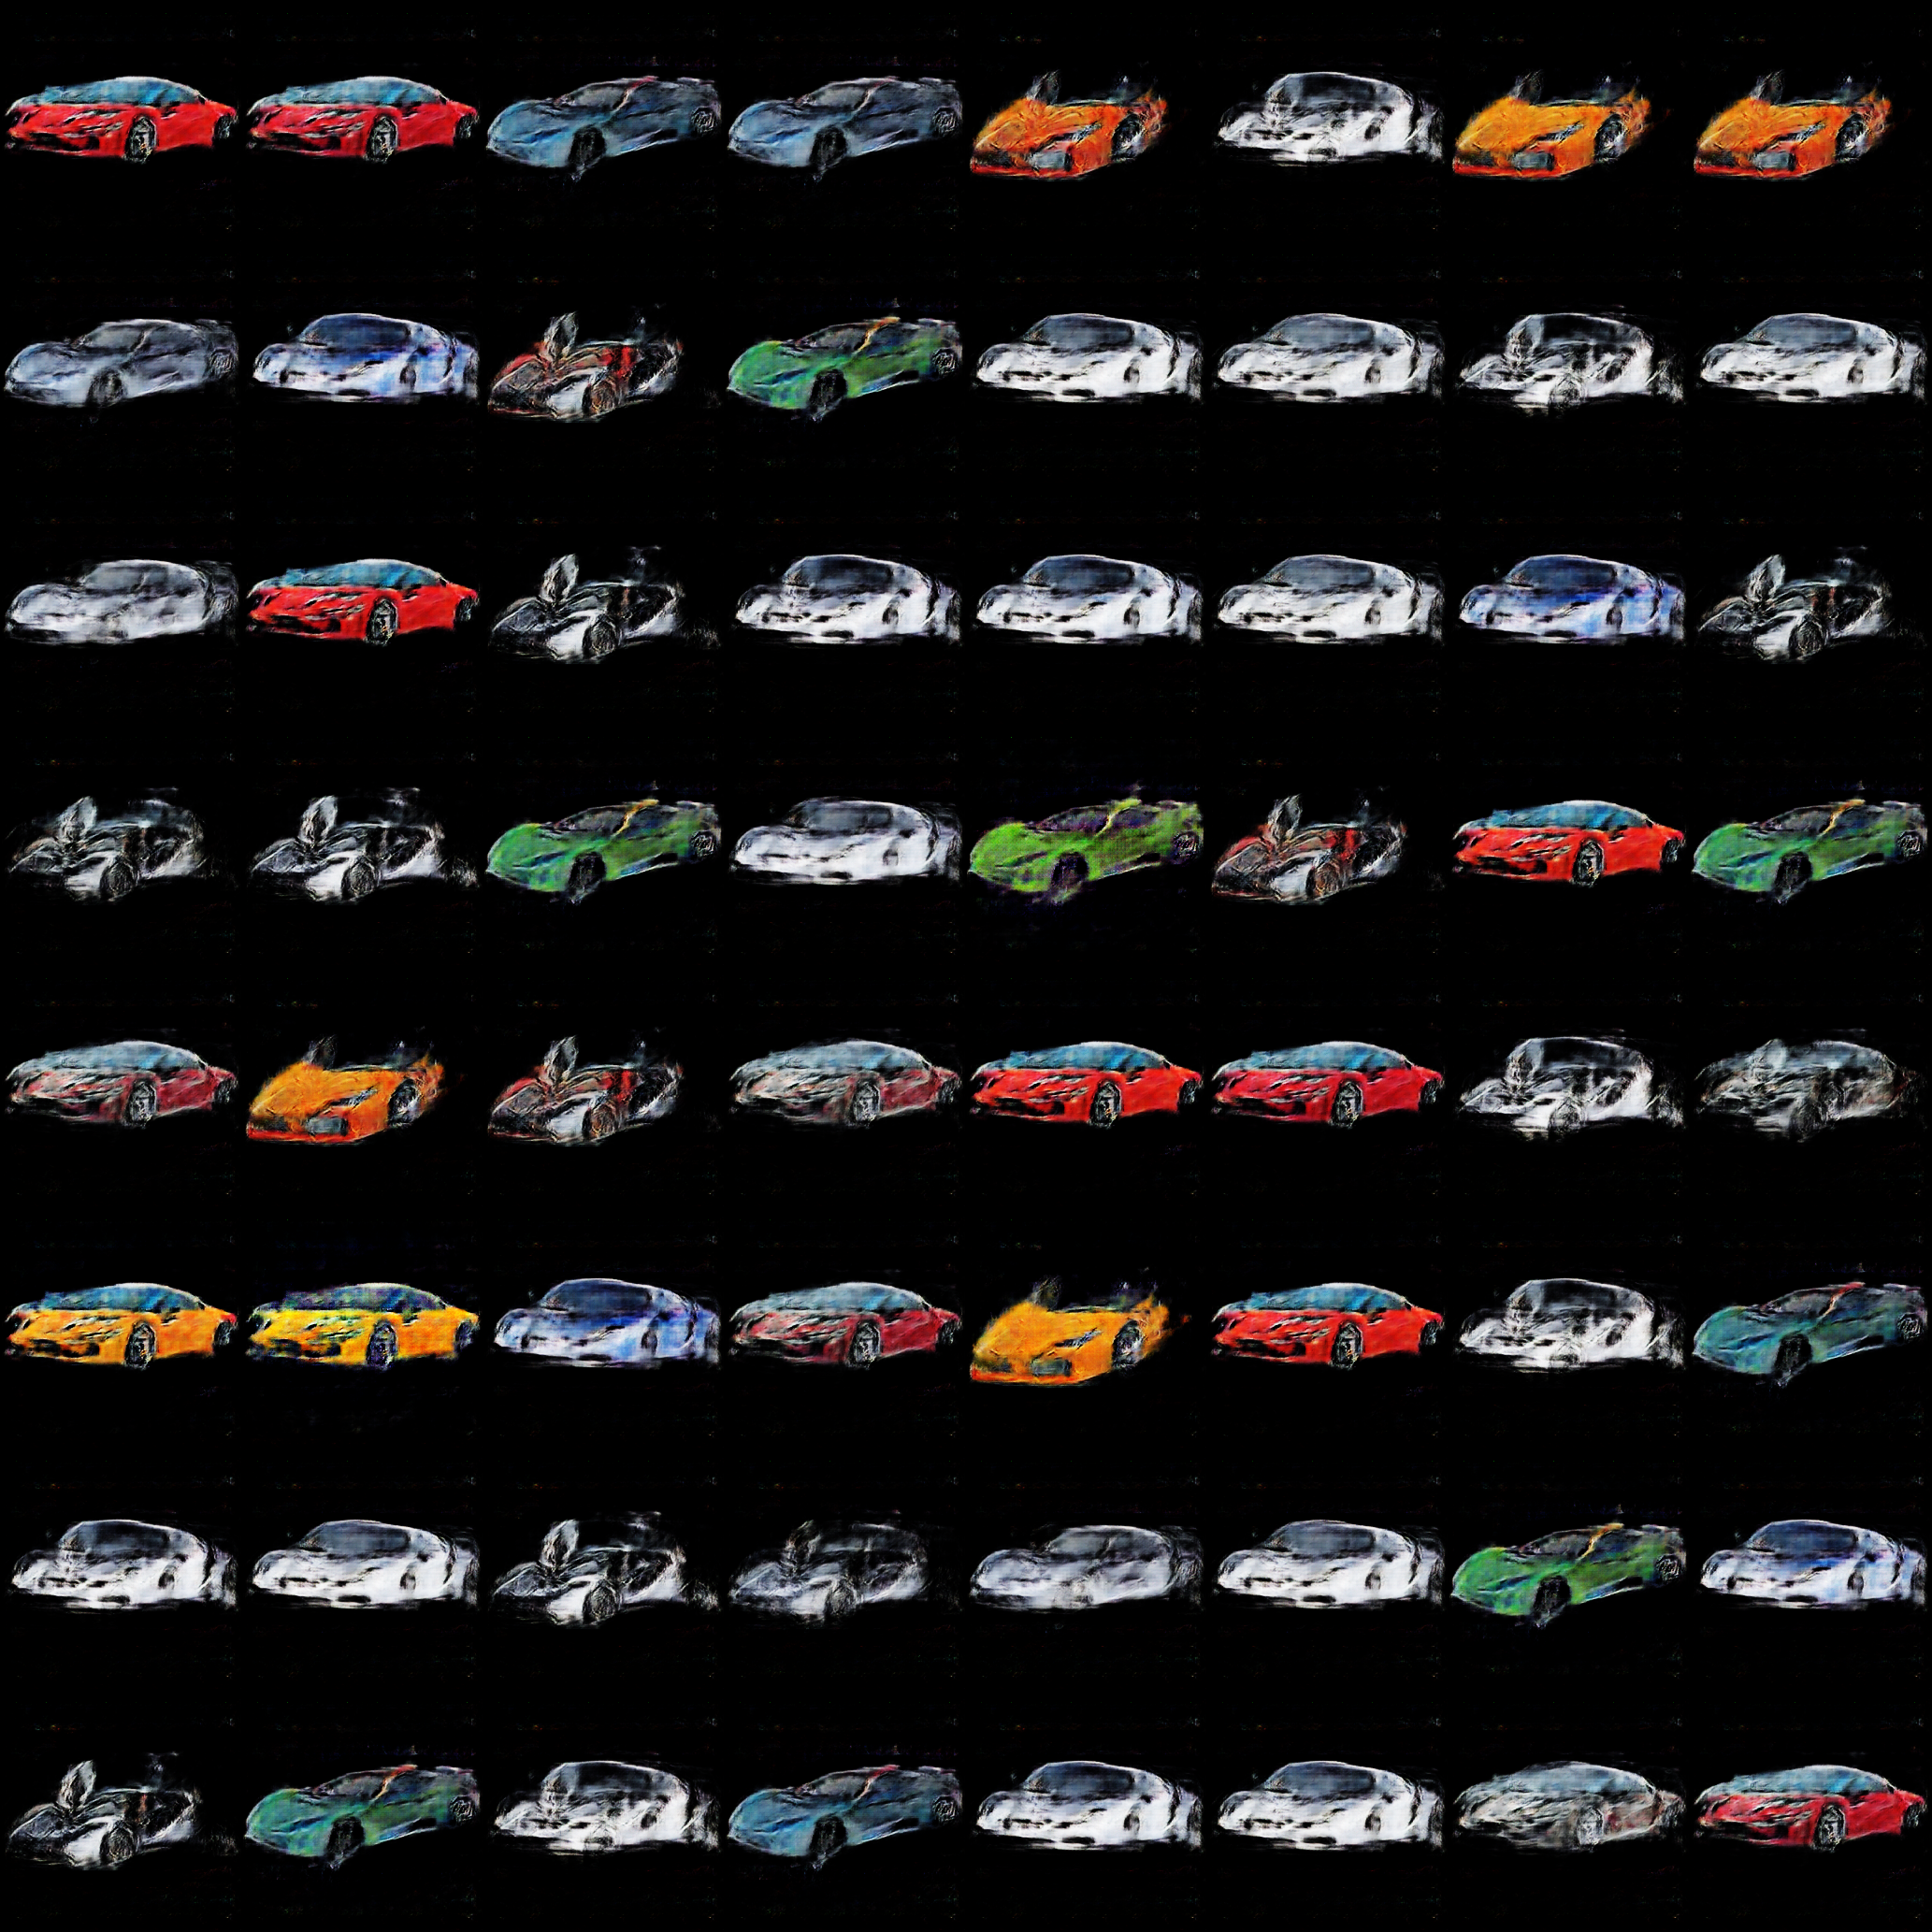

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')
